In [3]:
import pandas as pd

orders = pd.read_csv('List of Orders.csv')
details = pd.read_csv('Order Details.csv')
targets = pd.read_csv('Sales target.csv')

print(orders.head())
print(details.head())
print(targets.head())


  Order ID  Order Date CustomerName           State       City
0  B-25601  01-04-2018       Bharat         Gujarat  Ahmedabad
1  B-25602  01-04-2018        Pearl     Maharashtra       Pune
2  B-25603  03-04-2018        Jahan  Madhya Pradesh     Bhopal
3  B-25604  03-04-2018       Divsha       Rajasthan     Jaipur
4  B-25605  05-04-2018      Kasheen     West Bengal    Kolkata
  Order ID  Amount  Profit  Quantity     Category      Sub-Category
0  B-25601  1275.0 -1148.0         7    Furniture         Bookcases
1  B-25601    66.0   -12.0         5     Clothing             Stole
2  B-25601     8.0    -2.0         3     Clothing       Hankerchief
3  B-25601    80.0   -56.0         4  Electronics  Electronic Games
4  B-25602   168.0  -111.0         2  Electronics            Phones
  Month of Order Date   Category   Target
0              Apr-18  Furniture  10400.0
1              May-18  Furniture  10500.0
2              Jun-18  Furniture  10600.0
3              Jul-18  Furniture  10800.0
4   

In [4]:
import psycopg2

# Prompt the user to securely enter PostgreSQL connection details
db_name = input("Enter your PostgreSQL database name: ")
db_user = input("Enter your PostgreSQL username: ")
db_pass = input("Enter your PostgreSQL password: ")
db_host = input("Enter your database host (default: localhost): ") or "localhost"
db_port = input("Enter your database port (default: 5432): ") or "5432"

# Connect to the database using user inputs
conn = psycopg2.connect(
    dbname=db_name,
    user=db_user,
    password=db_pass,
    host=db_host,
    port=db_port
)
cur = conn.cursor()
print("✅ Connected to the database!")


✅ Connected to the database!


In [5]:
# Create the 'list_of_orders' table if it does not already exist.
# The table will store order details with the following columns:
# - "Order ID": Unique identifier for each order (Primary Key)
# - "Order Date": Date of the order
# - "CustomerName": Name of the customer
# - "State": State where the order was placed
# - "City": City where the order was placed

cur.execute("""
CREATE TABLE IF NOT EXISTS list_of_orders (
    "Order ID" TEXT PRIMARY KEY,
    "Order Date" DATE,
    "CustomerName" TEXT,
    "State" TEXT,
    "City" TEXT
);
""")
conn.commit()
print("✅ Table created!")


✅ Table created!


In [6]:
# Create the 'order_details' table if it does not already exist.
# This table stores detailed information for each order, including:
# - "Order ID": Unique identifier for each order (Primary Key)
# - "Amount": Total sales amount for the order
# - "Profit": Profit earned from the order
# - "Quantity": Number of items in the order
# - "Category": Main category of the product(s)
# - "Sub-Category": Sub-category of the product(s)

cur.execute("""
CREATE TABLE IF NOT EXISTS order_details (
    "Order ID" TEXT PRIMARY KEY,
    "Amount" NUMERIC,
    "Profit" NUMERIC,
    "Quantity" INTEGER,
    "Category" TEXT,
    "Sub-Category" TEXT
);
""")
conn.commit()
print("✅ Order Details table created!")


✅ Order Details table created!


In [7]:
# Create the 'sales_target' table if it does not already exist.
# This table stores sales target goals for each product category and month:
# - "Month of Order Date": Month and year for the sales target (e.g., "Jan-25")
# - "Category": Product category for the target
# - "Target": Sales target amount for that category and month

cur.execute("""
CREATE TABLE IF NOT EXISTS sales_target (
    "Month of Order Date" TEXT,
    "Category" TEXT,
    "Target" NUMERIC
);
""")
conn.commit()
print("✅ Sales target table created!")


✅ Sales target table created!


In [8]:
# Import data from 'List of Orders.csv' into the 'list_of_orders' table.
# - Converts empty strings to None for consistency with NULL values in the database.
# - Converts order dates from 'DD-MM-YYYY' to 'YYYY-MM-DD' format for PostgreSQL compatibility.
# - Skips rows that have missing or blank 'Order ID' values.
# - Uses ON CONFLICT ("Order ID") DO NOTHING to ignore duplicate Order IDs and prevent errors.
# - Commits all changes after import.

import csv
from datetime import datetime

def empty_to_none(row):
    return [r if r != "" else None for r in row]

def fix_date(date_str):
    try:
        return datetime.strptime(date_str, '%d-%m-%Y').strftime('%Y-%m-%d')
    except Exception:
        return date_str

with open('List of Orders.csv', 'r') as f:
    next(f)
    reader = csv.reader(f)
    for raw_row in reader:
        row = empty_to_none(raw_row)
        if row[1] is not None:
            row[1] = fix_date(row[1])
        # SKIP rows that have None as Order ID (first column)
        if row[0] is not None:
            cur.execute("""
                INSERT INTO list_of_orders (
                    "Order ID", "Order Date", "CustomerName", "State", "City"
                ) VALUES (%s, %s, %s, %s, %s)
                ON CONFLICT ("Order ID") DO NOTHING;
            """, row)

conn.commit()
print("✅ List of Orders.csv data imported with blank rows skipped!")


✅ List of Orders.csv data imported with blank rows skipped!


In [9]:
# Import data from 'Order Details.csv' into the 'order_details' table.
# - Converts empty strings to None for proper handling of missing values in the database.
# - Skips any record that has a missing or blank 'Order ID' (first column is required as a primary key).
# - Uses ON CONFLICT ("Order ID") DO NOTHING to gracefully skip duplicate Order IDs.
# - Commits all changes after the import is complete.

import csv

def empty_to_none(row):
    return [r if r != "" else None for r in row]

with open('Order Details.csv', 'r') as f:
    next(f)  # skip header
    reader = csv.reader(f)
    for raw_row in reader:
        row = empty_to_none(raw_row)
        # Skip rows with None as Order ID (first column required)
        if row[0] is not None:
            cur.execute("""
                INSERT INTO order_details (
                    "Order ID", "Amount", "Profit", "Quantity", "Category", "Sub-Category"
                ) VALUES (%s, %s, %s, %s, %s, %s)
                ON CONFLICT ("Order ID") DO NOTHING;
            """, row)

conn.commit()
print("✅ Order Details.csv data imported! (duplicate rows skipped)")



✅ Order Details.csv data imported! (duplicate rows skipped)


In [10]:
# Import data from 'Sales target.csv' into the 'sales_target' table.
# - Converts empty strings to None for proper handling of missing values in the database.
# - Skips the header row while reading the CSV.
# - Assumes all data is clean, so there is no need for primary key constraints or ON CONFLICT logic.
# - Inserts all rows as they appear in the CSV.
# - Commits all changes after the import is complete.

import csv

def empty_to_none(row):
    return [r if r != "" else None for r in row]

with open('Sales target.csv', 'r') as f:
    next(f)  # Skip header row
    reader = csv.reader(f)
    for raw_row in reader:
        row = empty_to_none(raw_row)
        cur.execute("""
            INSERT INTO sales_target (
                "Month of Order Date", "Category", "Target"
            ) VALUES (%s, %s, %s);
        """, row)

conn.commit()
print("✅ Sales target CSV data imported!")


✅ Sales target CSV data imported!


In [11]:
# query gets sales targets and actual sales by category and month for target achievement analysis

cur.execute("""
-- Sales vs. Targets by Category & Month
SELECT
    st."Month of Order Date" AS month,           -- Month name (e.g., Apr-18)
    st."Category",                               -- Product category
    st."Target",                                 -- Target sales value
    CASE WHEN actuals.total_sales IS NULL THEN 0 ELSE actuals.total_sales END AS actual_sales,   -- Actual sales (sum)
    CASE WHEN actuals.total_sales IS NULL THEN -st."Target" ELSE (actuals.total_sales - st."Target") END AS gap  -- Difference
FROM sales_target st
LEFT JOIN (
    SELECT
        od."Category",
        to_char(lo."Order Date", 'Mon-YY') AS order_month,    -- Month format matches sales_target table
        SUM(od."Amount") AS total_sales                       -- Aggregate total sales amount
    FROM order_details od
    INNER JOIN list_of_orders lo USING ("Order ID")           -- Join to get order date
    GROUP BY od."Category", order_month
) actuals
ON st."Category" = actuals."Category"
AND st."Month of Order Date" = actuals.order_month            -- Match on category and month
ORDER BY month, st."Category";
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_targets = pd.DataFrame(rows, columns=colnames)

print(df_targets)


     month     Category    Target actual_sales        gap
0   Apr-18     Clothing  12000.00      7676.00   -4324.00
1   Apr-18  Electronics   9000.00      4384.00   -4616.00
2   Apr-18    Furniture  10400.00      5573.00   -4827.00
3   Aug-18     Clothing  14000.00      1357.00  -12643.00
4   Aug-18  Electronics   9000.00      3257.00   -5743.00
5   Aug-18    Furniture  10900.00      5951.00   -4949.00
6   Dec-18     Clothing  16000.00      3088.00  -12912.00
7   Dec-18  Electronics   9000.00      1158.00   -7842.00
8   Dec-18    Furniture  11400.00      3357.00   -8043.00
9   Feb-19     Clothing  16000.00      3510.00  -12490.00
10  Feb-19  Electronics  16000.00      5651.00  -10349.00
11  Feb-19    Furniture  11600.00      4556.00   -7044.00
12  Jan-19     Clothing  16000.00      5266.00  -10734.00
13  Jan-19  Electronics  16000.00      6503.00   -9497.00
14  Jan-19    Furniture  11500.00      5077.00   -6423.00
15  Jul-18     Clothing  14000.00      1116.00  -12884.00
16  Jul-18  El

In [12]:
# The code gets the total profit for each category from your order details.

cur.execute("""
SELECT "Category", SUM("Profit") AS total_profit
FROM order_details
GROUP BY "Category"
ORDER BY total_profit DESC;
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_profit_by_category = pd.DataFrame(rows, columns=colnames)

print(df_profit_by_category)


      Category total_profit
0     Clothing      4847.00
1    Furniture      1799.00
2  Electronics     -1841.00


In [13]:
# This code compares actual monthly sales to targets for each category and calculates the achievement ratio.
# It helps you check if sales targets are realistic, by showing how much of each target was met.

cur.execute("""
SELECT
    st."Month of Order Date" AS month,
    st."Category",
    st."Target",
    CASE WHEN actuals.total_sales IS NULL 
    THEN 0 
    ELSE actuals.total_sales 
    END AS actual_sales,
    CASE WHEN actuals.total_sales IS NULL 
    THEN -st."Target" 
    ELSE (actuals.total_sales - st."Target") 
    END AS gap,
    CASE WHEN st."Target" = 0 
    THEN NULL 
    ELSE
        ROUND(
            (CASE WHEN actuals.total_sales IS NULL 
            THEN 0 
            ELSE actuals.total_sales END) / st."Target", 2
        )
    END AS achievement_ratio
FROM sales_target st
LEFT JOIN (
    SELECT
        od."Category",
        to_char(lo."Order Date", 'Mon-YY') AS order_month,
        SUM(od."Amount") AS total_sales
    FROM order_details od
    INNER JOIN list_of_orders lo 
    USING ("Order ID")
    GROUP BY od."Category", order_month
) actuals
ON st."Category" = actuals."Category"
AND st."Month of Order Date" = actuals.order_month
ORDER BY month, st."Category";
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_target_achievement = pd.DataFrame(rows, columns=colnames)

print(df_target_achievement)


     month     Category    Target actual_sales        gap achievement_ratio
0   Apr-18     Clothing  12000.00      7676.00   -4324.00              0.64
1   Apr-18  Electronics   9000.00      4384.00   -4616.00              0.49
2   Apr-18    Furniture  10400.00      5573.00   -4827.00              0.54
3   Aug-18     Clothing  14000.00      1357.00  -12643.00              0.10
4   Aug-18  Electronics   9000.00      3257.00   -5743.00              0.36
5   Aug-18    Furniture  10900.00      5951.00   -4949.00              0.55
6   Dec-18     Clothing  16000.00      3088.00  -12912.00              0.19
7   Dec-18  Electronics   9000.00      1158.00   -7842.00              0.13
8   Dec-18    Furniture  11400.00      3357.00   -8043.00              0.29
9   Feb-19     Clothing  16000.00      3510.00  -12490.00              0.22
10  Feb-19  Electronics  16000.00      5651.00  -10349.00              0.35
11  Feb-19    Furniture  11600.00      4556.00   -7044.00              0.39
12  Jan-19  

/var/folders/_2/qrzg8rrn4dj_dcjsg5dtr0h40000gn/T/ipykernel_66643/292371949.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_targets_long, x='month', y='Amount', hue='Type', ci=None)


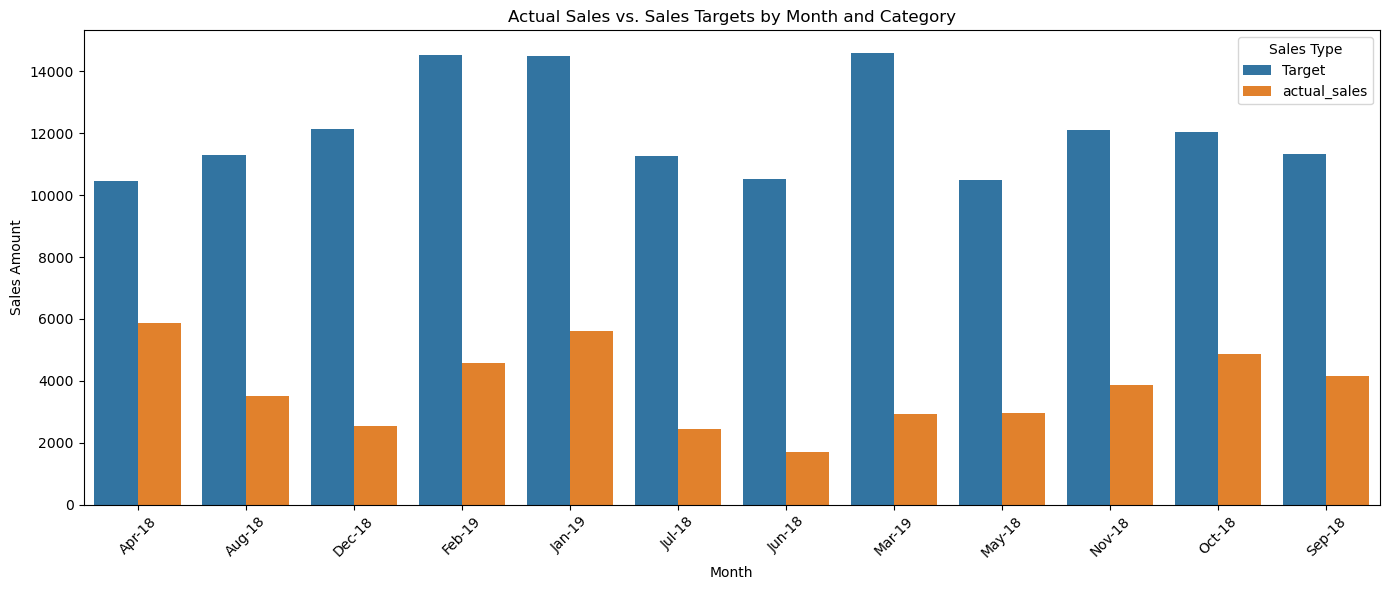

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# We'll use the DataFrame from your target achievement analysis
# df_target_achievement with columns: 'month', 'Category', 'Target', 'actual_sales', ...

# Create separate DataFrames for 'Target' and 'actual_sales'
df_target = df_target_achievement[['month', 'Category', 'Target']].copy()
df_target['Type'] = 'Target'
df_target = df_target.rename(columns={'Target': 'Amount'})

df_actual = df_target_achievement[['month', 'Category', 'actual_sales']].copy()
df_actual['Type'] = 'actual_sales'
df_actual = df_actual.rename(columns={'actual_sales': 'Amount'})

# Stack them together
df_targets_long = pd.concat([df_target, df_actual], ignore_index=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=df_targets_long, x='month', y='Amount', hue='Type', ci=None)

plt.xticks(rotation=45)
plt.title('Actual Sales vs. Sales Targets by Month and Category')
plt.ylabel('Sales Amount')
plt.xlabel('Month')
plt.legend(title='Sales Type')
plt.tight_layout()
plt.show()






In [15]:
# This code calculates total profit for each category from your order details.
# It loads the results into a DataFrame named df_profit_by_category for viewing

cur.execute("""
SELECT
    "Category",
    -- If you have a Sub-Category column, add: "Sub-Category",
    SUM("Profit") AS total_profit
FROM order_details
GROUP BY "Category"
ORDER BY total_profit DESC;
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_profit_by_category = pd.DataFrame(rows, columns=colnames)

print(df_profit_by_category)


      Category total_profit
0     Clothing      4847.00
1    Furniture      1799.00
2  Electronics     -1841.00


In [16]:
# code calculates total profit for each sub-category within every category from your order details table.

cur.execute("""
SELECT
    "Category",
    "Sub-Category",
    SUM("Profit") AS total_profit
FROM order_details
GROUP BY "Category", "Sub-Category"
ORDER BY total_profit DESC;
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_profit_by_subcategory = pd.DataFrame(rows, columns=colnames)

print(df_profit_by_subcategory)


       Category      Sub-Category total_profit
0     Furniture         Bookcases      4083.00
1   Electronics       Accessories      2170.00
2      Clothing             Stole      1275.00
3      Clothing             Saree      1166.00
4   Electronics          Printers       930.00
5      Clothing           T-shirt       783.00
6      Clothing       Hankerchief       765.00
7      Clothing          Trousers       435.00
8     Furniture       Furnishings       412.00
9     Furniture            Chairs       328.00
10     Clothing             Shirt       247.00
11     Clothing             Skirt        94.00
12     Clothing          Leggings        87.00
13     Clothing             Kurti        -5.00
14  Electronics  Electronic Games     -1990.00
15  Electronics            Phones     -2951.00
16    Furniture            Tables     -3024.00


/var/folders/_2/qrzg8rrn4dj_dcjsg5dtr0h40000gn/T/ipykernel_66643/2113426138.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


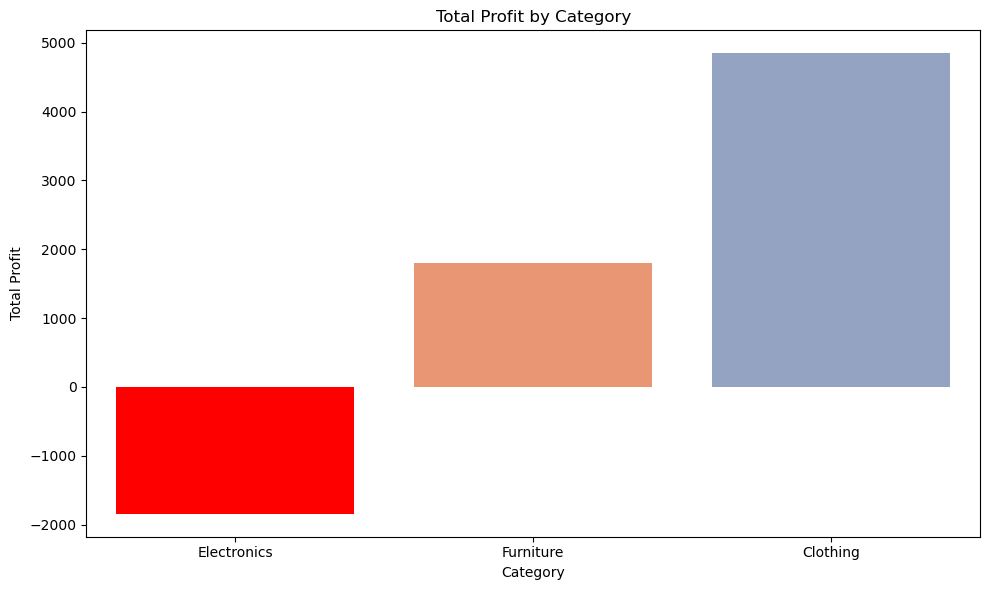

In [17]:
# This code plots total profit by product category and highlights any categories with negative profit in red.
# It helps you quickly identify which categories are most and least profitable.

import seaborn as sns
import matplotlib.pyplot as plt

# Plot total profit by Category from your profit summary DataFrame
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_profit_by_category.sort_values('total_profit'),
    x='Category',
    y='total_profit',
    palette='Set2'
)
plt.title('Total Profit by Category')
plt.xlabel('Category')
plt.ylabel('Total Profit')

# Highlight negative profits in red
for p in ax.patches:
    if p.get_height() < 0:
        p.set_facecolor('red')

plt.tight_layout()
plt.show()


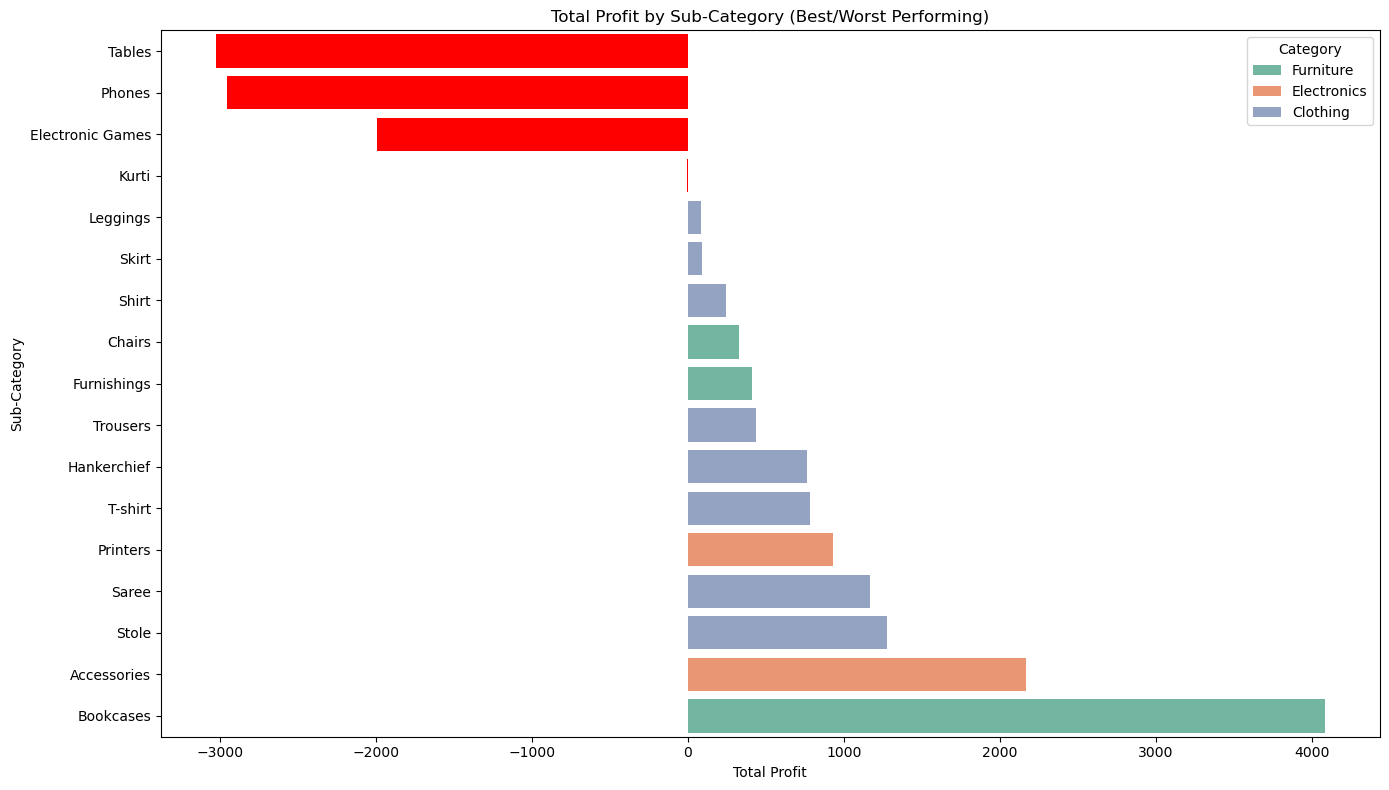

In [18]:
# This code visualizes total profit for each sub-category, with colors for main categories.
# It highlights sub-categories with negative profit in red, making underperformers easy to spot.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot total profit by Sub-Category, colored by Category
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_profit_by_subcategory.sort_values('total_profit'),
    y='Sub-Category',
    x='total_profit',
    hue='Category',
    dodge=False,
    palette='Set2'
)
plt.title('Total Profit by Sub-Category (Best/Worst Performing)')
plt.xlabel('Total Profit')
plt.ylabel('Sub-Category')
plt.legend(title='Category')

# Highlight negative profits in red
for p in ax.patches:
    if p.get_width() < 0:
        p.set_facecolor('red')

plt.tight_layout()
plt.show()


In [19]:
# This code finds the total purchase amount for each customer by combining orders and their details.

cur.execute("""
    SELECT
        lo."CustomerName",
        SUM(od."Amount") AS total_purchase
    FROM list_of_orders lo
    INNER JOIN order_details od ON lo."Order ID" = od."Order ID"
    GROUP BY lo."CustomerName"
    ORDER BY total_purchase DESC;
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
df_customers = pd.DataFrame(rows, columns=colnames)
print(df_customers)


    CustomerName total_purchase
0        Surabhi        3972.00
1         Mukesh        2763.00
2          Rohan        2311.00
3         Soumya        2246.00
4      Shrichand        2169.00
..           ...            ...
327       Ashwin          11.00
328        Stuti          11.00
329    Maithilee          10.00
330      Nishant          10.00
331       Kushal          10.00

[332 rows x 2 columns]


In [20]:
# This code calculates total sales for each city by joining orders with their details.

cur.execute("""
SELECT
    lo."City",
    SUM(od."Amount") AS total_sales
FROM list_of_orders lo
INNER JOIN order_details od ON lo."Order ID" = od."Order ID"
GROUP BY lo."City"
ORDER BY total_sales DESC;
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_sales_by_city = pd.DataFrame(rows, columns=colnames)

print(df_sales_by_city)


                  City total_sales
0               Mumbai    19732.00
1               Indore    19314.00
2               Bhopal    10660.00
3           Chandigarh     9869.00
4            Bangalore     7067.00
5                 Pune     6866.00
6                Patna     6576.00
7   Thiruvananthapuram     5974.00
8                Delhi     5098.00
9              Kolkata     4496.00
10              Jaipur     4222.00
11              Kohima     3769.00
12           Ahmedabad     3760.00
13           Hyderabad     3235.00
14             Kashmir     3222.00
15            Amritsar     3133.00
16               Surat     2857.00
17             Udaipur     2770.00
18             Gangtok     2695.00
19             Lucknow     2627.00
20             Chennai     2340.00
21               Simla     1872.00
22                 Goa     1549.00
23           Allahabad     1462.00


In [21]:
# This code calculates total sales for each state by joining orders with their details.

cur.execute("""
SELECT
    lo."State",
    SUM(od."Amount") AS total_sales
FROM list_of_orders lo
INNER JOIN order_details od ON lo."Order ID" = od."Order ID"
GROUP BY lo."State"
ORDER BY total_sales DESC;
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_sales_by_state = pd.DataFrame(rows, columns=colnames)

print(df_sales_by_state)


                State total_sales
0      Madhya Pradesh    30397.00
1         Maharashtra    26598.00
2              Punjab     7615.00
3           Karnataka     7067.00
4           Rajasthan     6992.00
5             Gujarat     6617.00
6               Bihar     6576.00
7             Kerala      5974.00
8             Haryana     5387.00
9               Delhi     4675.00
10        West Bengal     4496.00
11      Uttar Pradesh     4089.00
12           Nagaland     3769.00
13     Andhra Pradesh     3235.00
14  Jammu and Kashmir     3222.00
15             Sikkim     2695.00
16         Tamil Nadu     2340.00
17   Himachal Pradesh     1872.00
18                Goa     1549.00


In [22]:
# summarizes order count, total sales, and average order value for each state.

cur.execute("""
SELECT
    lo."State",
    COUNT(DISTINCT lo."Order ID") AS order_count,
    SUM(od."Amount") AS total_sales,
    CASE WHEN COUNT(DISTINCT lo."Order ID") = 0 THEN 0
         ELSE ROUND(SUM(od."Amount") / COUNT(DISTINCT lo."Order ID"), 2)
    END AS avg_order_value
FROM list_of_orders lo
INNER JOIN order_details od ON lo."Order ID" = od."Order ID"
GROUP BY lo."State"
ORDER BY avg_order_value DESC;
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_state_order_summary = pd.DataFrame(rows, columns=colnames)

print(df_state_order_summary)


                State  order_count total_sales avg_order_value
0               Bihar           16     6576.00          411.00
1             Haryana           14     5387.00          384.79
2             Kerala            16     5974.00          373.38
3           Karnataka           21     7067.00          336.52
4              Punjab           25     7615.00          304.60
5      Madhya Pradesh          101    30397.00          300.96
6         Maharashtra           90    26598.00          295.53
7          Tamil Nadu            8     2340.00          292.50
8            Nagaland           15     3769.00          251.27
9             Gujarat           27     6617.00          245.07
10  Jammu and Kashmir           14     3222.00          230.14
11             Sikkim           12     2695.00          224.58
12          Rajasthan           32     6992.00          218.50
13     Andhra Pradesh           15     3235.00          215.67
14              Delhi           22     4675.00         

/var/folders/_2/qrzg8rrn4dj_dcjsg5dtr0h40000gn/T/ipykernel_66643/3097027587.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_states, x='State', y='total_sales', palette='tab10')


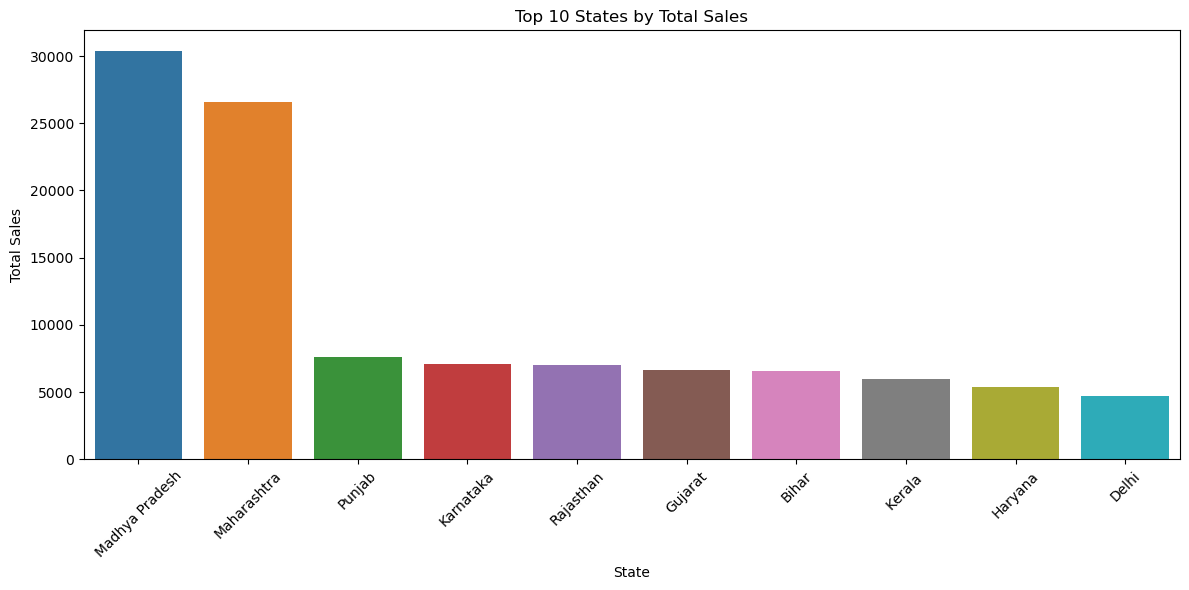

In [23]:
# This code visualizes the top 10 states based on total sales.

import seaborn as sns
import matplotlib.pyplot as plt

# Select top 10 states by total sales
df_top_states = df_state_order_summary.sort_values('total_sales', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_states, x='State', y='total_sales', palette='tab10')
plt.title('Top 10 States by Total Sales')
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



/var/folders/_2/qrzg8rrn4dj_dcjsg5dtr0h40000gn/T/ipykernel_66643/1764566009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_customers, x='CustomerName', y='total_purchase', palette='Set2')


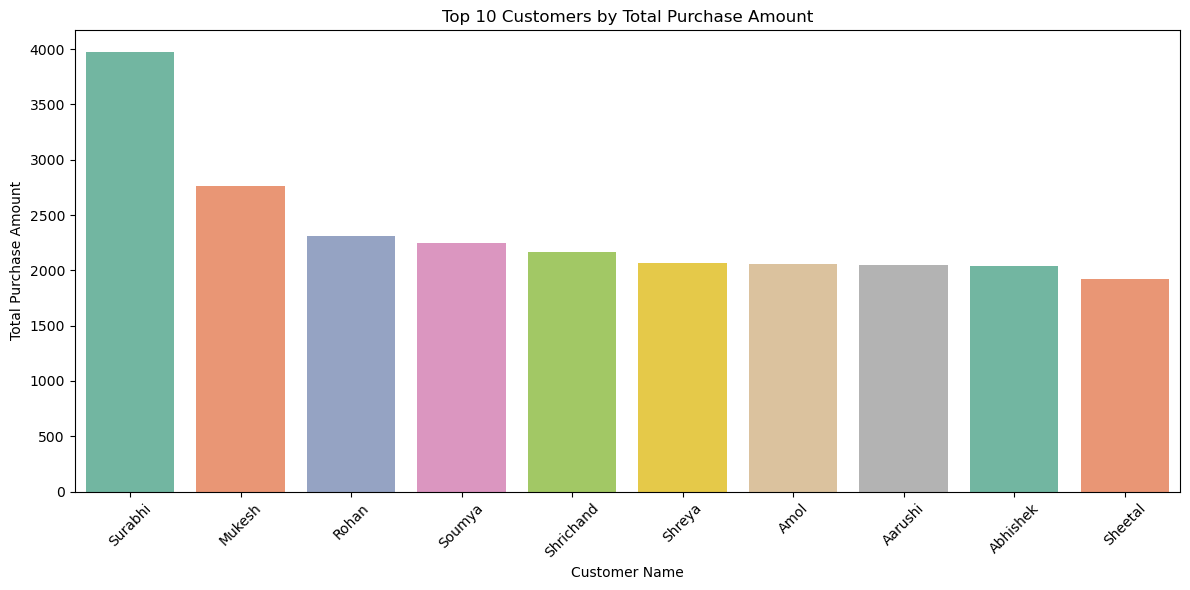

In [24]:
# This code visualizes the top 10 customers ranked by their total purchase amount.

df_top_customers = df_customers.sort_values('total_purchase', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_customers, x='CustomerName', y='total_purchase', palette='Set2')
plt.title('Top 10 Customers by Total Purchase Amount')
plt.xlabel('Customer Name')
plt.ylabel('Total Purchase Amount')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [25]:
# This code summarizes total monthly sales for each year from your orders data.

cur.execute("""
    SELECT 
        EXTRACT(YEAR FROM lo."Order Date") AS year,
        EXTRACT(MONTH FROM lo."Order Date") AS month,
        SUM(od."Amount") AS total_sales
    FROM list_of_orders lo
    JOIN order_details od ON lo."Order ID" = od."Order ID"
    GROUP BY year, month
    ORDER BY year, month;
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_monthly_sales = pd.DataFrame(rows, columns=colnames)

print(df_monthly_sales)


    year month total_sales
0   2018     4    17633.00
1   2018     5     8910.00
2   2018     6     5091.00
3   2018     7     7337.00
4   2018     8    10565.00
5   2018     9    12447.00
6   2018    10    14637.00
7   2018    11    11627.00
8   2018    12     7603.00
9   2019     1    16846.00
10  2019     2    13717.00
11  2019     3     8752.00


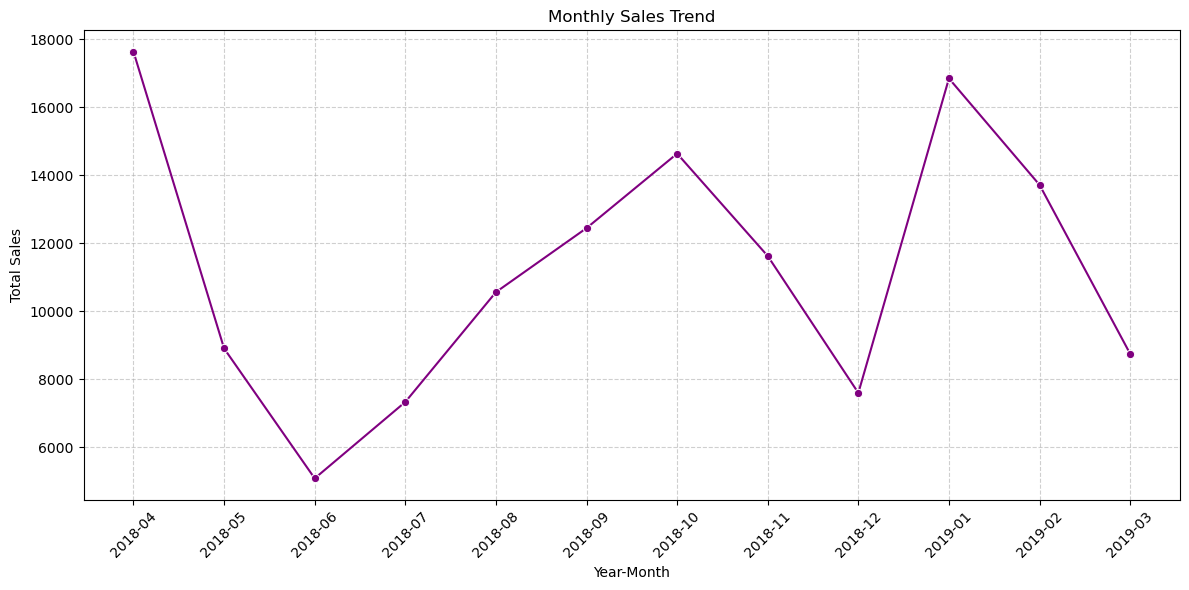

In [26]:
# This code visualizes monthly sales trends over multiple years with a line plot.

import seaborn as sns
import matplotlib.pyplot as plt

# Combine year and month into 'year_month' for neat x-axis labels
df_monthly_sales['year_month'] = df_monthly_sales['year'].astype(int).astype(str) + '-' + df_monthly_sales['month'].astype(int).astype(str).str.zfill(2)
df_monthly_sales = df_monthly_sales.sort_values(by=['year', 'month'])

plt.figure(figsize=(12, 6))
sns.lineplot(x='year_month', y='total_sales', data=df_monthly_sales, marker="o", color="purple")
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trend')
plt.grid(True, which='major', linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
# This code summarizes total quantity and total profit for each product category.

cur.execute("""
    SELECT 
      "Category",
        SUM("Quantity") AS total_quantity,
        SUM("Profit") AS total_profit   
    FROM order_details 
    GROUP BY "Category"
    ORDER BY total_profit DESC      
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_category_summary = pd.DataFrame(rows, columns=colnames)

print(df_category_summary)


      Category  total_quantity total_profit
0     Clothing            1216      4847.00
1    Furniture             320      1799.00
2  Electronics             377     -1841.00


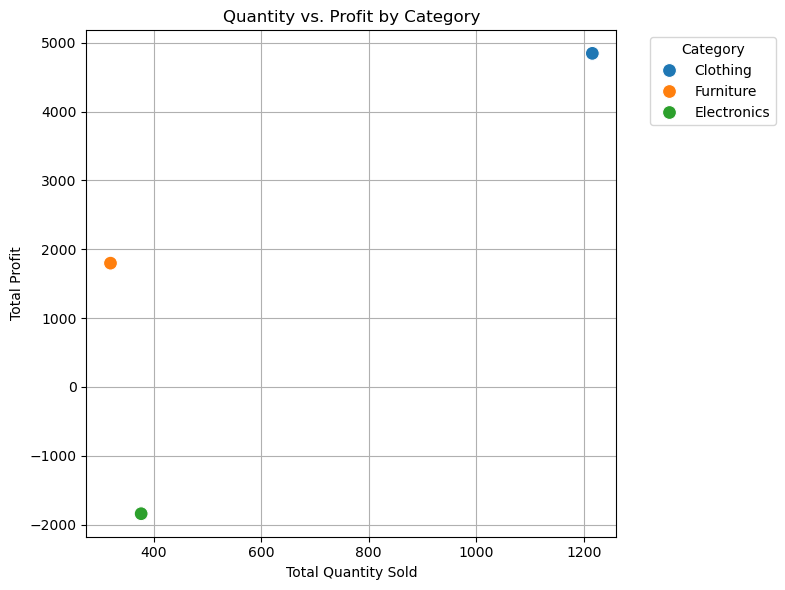

In [28]:
# This code creates a scatter plot showing the relationship between quantity sold and profit for each category.

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_category_summary,
    x="total_quantity",
    y="total_profit",
    hue="Category",         # Color by category
    s=100,
)

plt.xlabel("Total Quantity Sold")
plt.ylabel("Total Profit")
plt.title("Quantity vs. Profit by Category")
plt.grid(True)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [29]:
# This code summarizes total profit and quantity for each sub-category within every product category.

cur.execute("""
    SELECT 
        "Category",
        "Sub-Category",
        SUM("Profit") AS total_profit,
        SUM("Quantity") AS total_quantity    
    FROM order_details
    GROUP BY "Category", "Sub-Category"
    ORDER BY total_profit DESC
""")
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]

df_subcategory_summary = pd.DataFrame(rows, columns=colnames)

print(df_subcategory_summary)


       Category      Sub-Category total_profit  total_quantity
0     Furniture         Bookcases      4083.00             122
1   Electronics       Accessories      2170.00             107
2      Clothing             Stole      1275.00             262
3      Clothing             Saree      1166.00             246
4   Electronics          Printers       930.00              91
5      Clothing           T-shirt       783.00             112
6      Clothing       Hankerchief       765.00             247
7      Clothing          Trousers       435.00              31
8     Furniture       Furnishings       412.00             118
9     Furniture            Chairs       328.00              66
10     Clothing             Shirt       247.00              87
11     Clothing             Skirt        94.00             105
12     Clothing          Leggings        87.00              70
13     Clothing             Kurti        -5.00              56
14  Electronics  Electronic Games     -1990.00         

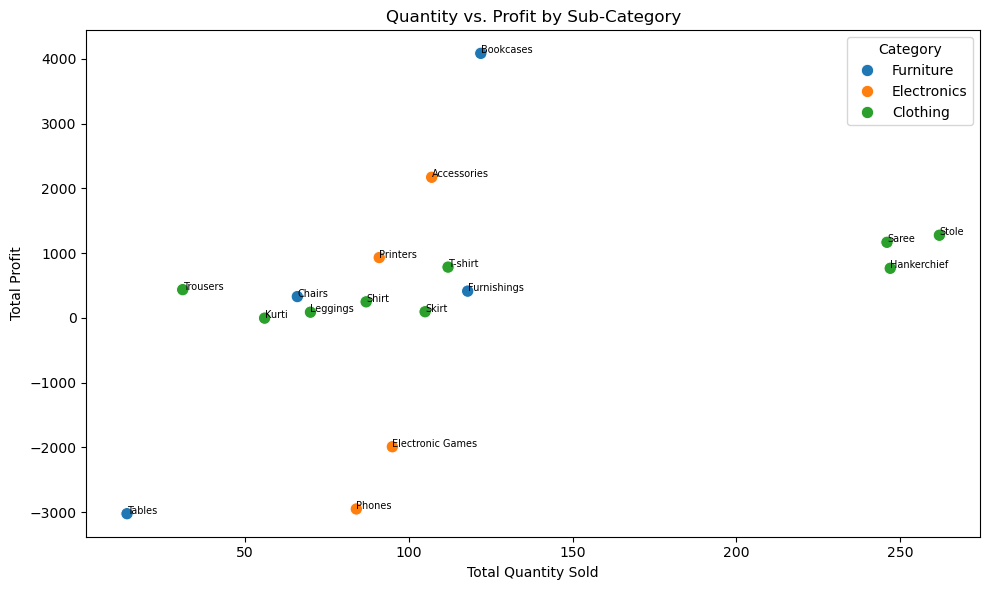

In [30]:
# This code creates a scatter plot of quantity vs. profit for each sub-category, with annotations for clarity.

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_subcategory_summary,
    x="total_quantity",
    y="total_profit",
    hue="Category",
    s=80,
)

# Annotate each point with sub-category names
for i, row in df_subcategory_summary.iterrows():
    plt.text(
        row["total_quantity"],
        row["total_profit"],
        row["Sub-Category"],
        fontsize=7
    )

plt.xlabel("Total Quantity Sold")
plt.ylabel("Total Profit")
plt.title("Quantity vs. Profit by Sub-Category")
plt.legend(title="Category")
plt.tight_layout()
plt.show()


In [37]:
# Category-wise sales by state: summarizes regional performance for each product category
sql_catregion = """
SELECT d."Category", o."State", SUM(d."Amount") AS Sales
FROM order_details d
JOIN list_of_orders o ON d."Order ID" = o."Order ID"
GROUP BY d."Category", o."State"
ORDER BY d."Category", Sales DESC;
"""
catregion_sales = pd.read_sql_query(sql_catregion, conn)
print(catregion_sales)



       Category              State    sales
0      Clothing     Madhya Pradesh   7945.0
1      Clothing        Maharashtra   6123.0
2      Clothing            Gujarat   4176.0
3      Clothing      Uttar Pradesh   3099.0
4      Clothing        West Bengal   3092.0
5      Clothing          Karnataka   2976.0
6      Clothing          Rajasthan   2508.0
7      Clothing            Kerala    2478.0
8      Clothing            Haryana   2128.0
9      Clothing             Punjab   2026.0
10     Clothing              Delhi   1834.0
11     Clothing           Nagaland   1480.0
12     Clothing             Sikkim   1163.0
13     Clothing  Jammu and Kashmir   1160.0
14     Clothing     Andhra Pradesh   1080.0
15     Clothing   Himachal Pradesh    871.0
16     Clothing                Goa    668.0
17     Clothing              Bihar    354.0
18     Clothing         Tamil Nadu    291.0
19  Electronics     Madhya Pradesh  13295.0
20  Electronics        Maharashtra  13120.0
21  Electronics              Bih

/var/folders/_2/qrzg8rrn4dj_dcjsg5dtr0h40000gn/T/ipykernel_66643/539775387.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  catregion_sales = pd.read_sql_query(sql_catregion, conn)


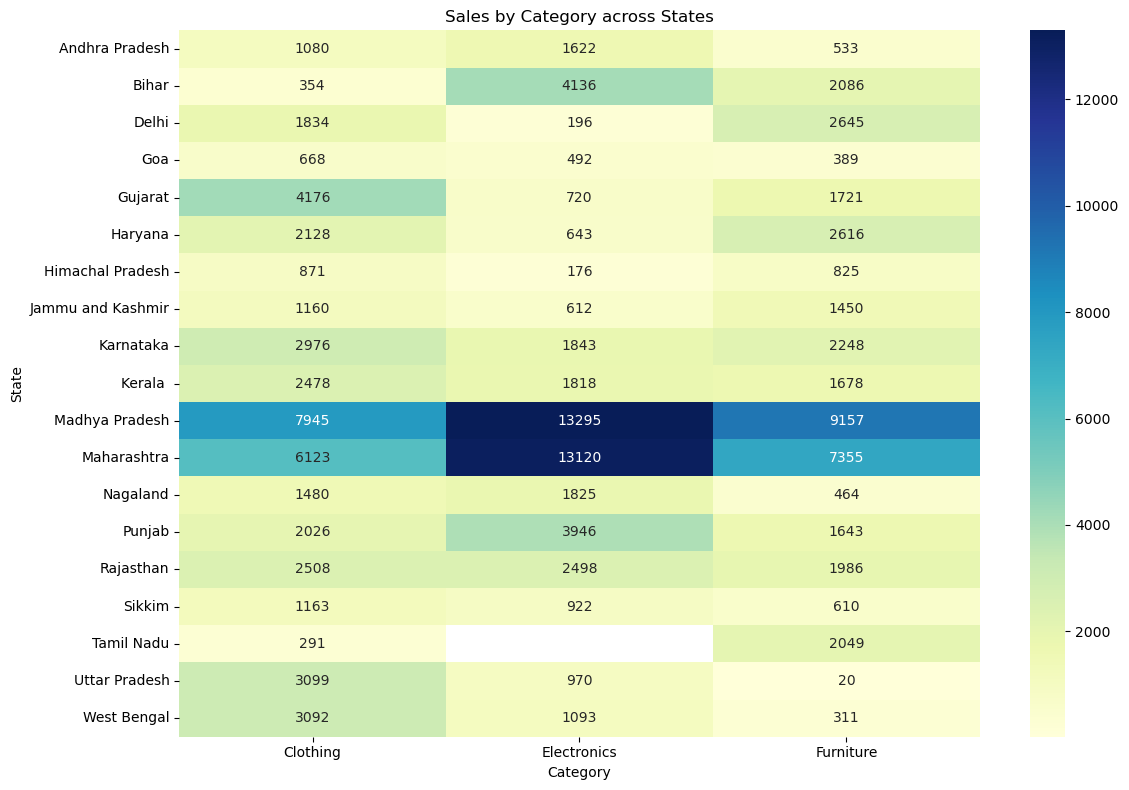

In [40]:
# Heatmap: Regional sales by category and state for fast visual comparison of top markets and products
pivot = catregion_sales.pivot(index="State", columns="Category", values="sales")

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Sales by Category across States")
plt.xlabel("Category")
plt.ylabel("State")
plt.tight_layout()
plt.show()




In [41]:
# Gets total sales by category and sub-category for detailed product segment analysis
sql_subcat = """
SELECT "Category", "Sub-Category", SUM("Amount") AS total_sales
FROM order_details
GROUP BY "Category", "Sub-Category"
ORDER BY "Category", total_sales DESC;
"""
subcat_sales = pd.read_sql_query(sql_subcat, conn)
print(subcat_sales)


       Category      Sub-Category  total_sales
0      Clothing             Saree      17831.0
1      Clothing             Stole       7583.0
2      Clothing          Trousers       7109.0
3      Clothing       Hankerchief       4362.0
4      Clothing           T-shirt       3205.0
5      Clothing             Shirt       2535.0
6      Clothing             Kurti       1154.0
7      Clothing          Leggings        851.0
8      Clothing             Skirt        822.0
9   Electronics          Printers      16822.0
10  Electronics  Electronic Games      11942.0
11  Electronics            Phones      11691.0
12  Electronics       Accessories       9472.0
13    Furniture         Bookcases      25800.0
14    Furniture            Chairs       5724.0
15    Furniture       Furnishings       4295.0
16    Furniture            Tables       3967.0


/var/folders/_2/qrzg8rrn4dj_dcjsg5dtr0h40000gn/T/ipykernel_66643/1537081405.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  subcat_sales = pd.read_sql_query(sql_subcat, conn)


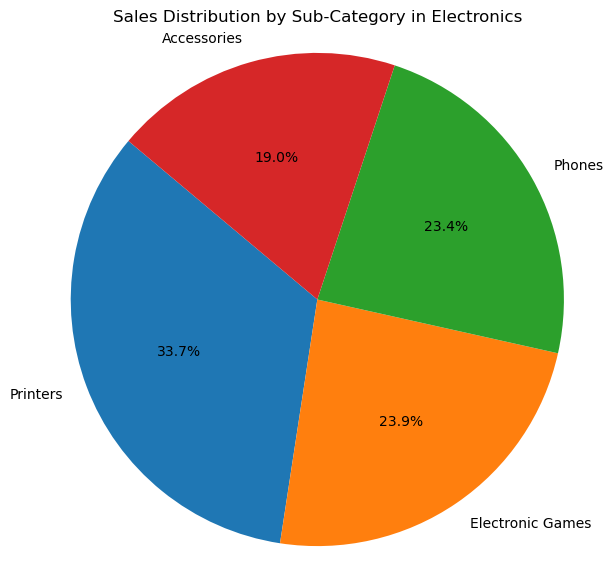

In [42]:
# Pie chart visualizes sales distribution across sub-categories within the selected product category
category = 'Electronics'  # Change to any category you want
data = subcat_sales[subcat_sales['Category'] == category]

plt.figure(figsize=(7, 7))
plt.pie(data['total_sales'], labels=data['Sub-Category'], autopct='%1.1f%%', startangle=140)
plt.title(f'Sales Distribution by Sub-Category in {category}')
plt.axis('equal')
plt.show()


<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/my_project/lib/python3.10/site-packages/matplotlib/pyplot.py'>

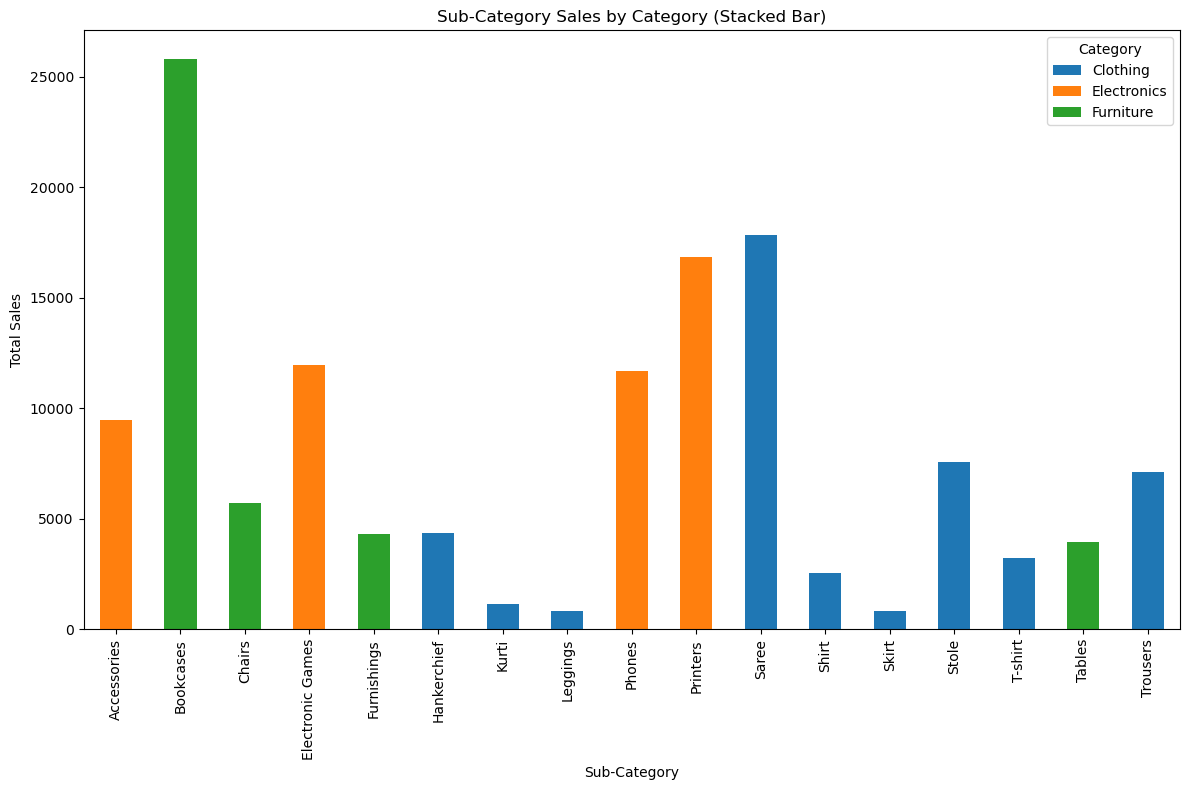

In [43]:
# Stacked bar chart compares sales totals across sub-categories and categories for deeper product insights
bar_data = subcat_sales.pivot(index='Sub-Category', columns='Category', values='total_sales').fillna(0)

bar_data.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Sub-Category Sales by Category (Stacked Bar)')
plt.xlabel('Sub-Category')
plt.ylabel('Total Sales')
plt.tight_layout()
plt
